##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Regressão: Preveja consumo de combustível

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />Veja em TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Execute em Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/pt/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Veja a fonte em GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/pt/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Baixe o notebook</a>
  </td>
</table>

Note: A nossa comunidade TensorFlow traduziu estes documentos. Como as traduções da comunidade são *o melhor esforço*, não há garantias de que sejam uma reflexão exata e atualizada da [documentação oficial em Inglês](https://www.tensorflow.org/?hl=en). Se tem alguma sugestão para melhorar esta tradução, por favor envie um pull request para o repositório do GitHub [tensorflow/docs](https://github.com/tensorflow/docs). Para se voluntariar para escrever ou rever as traduções da comunidade, contacte a [lista docs@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs).

Em um problema de regressão, o objetivo é prever as saídas (*outputs*) de um valor contínuo, como um preço ou probabilidade. Em contraste de problemas de classificação, onde temos o próposito de escolher uma classe em uma lista de classificações (por exemplo, se uma imagem contem uma maçã ou laranja, assim reconhecendo qual fruta é representada na imagem).

Este *notebook* usa a clássica base de dados [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) e constrói um modelo para prever a economia de combustiveis de automóveis do final dos anos 1970, inicio dos anos 1980. Para isso, forneceremos um modelo com descrição de vários automóveis desse período. Essa descrição inclui atributos como: cilindros, deslocamento, potência do motor, e peso.

Este exemplo usa a API `tf.keras`. Veja [este guia](https://www.tensorflow.org/guide/keras) para mais detalhes.

In [3]:
# Use seaborn para pairplot
!pip install -q seaborn

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


## Base de dados Auto MPG

A base de dados está disponível  em [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Pegando os dados
Primeiro baixe a base de dados dos automóveis.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/home/kbuilder/.keras/datasets/auto-mpg.data'

Utilizando o pandas, impoorte os dados:

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpe os dados

Esta base contém alguns valores não conhecidos (*unknown*).

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Para manter esse tutorial básico, remova as linhas com esses valores não conhecidos.

In [8]:
dataset = dataset.dropna()

A coluna "Origin" é uma coluna categórica e não numérica. Logo converta para *one-hot* :

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Separando dados de treinamento e teste

Agora separe os dados em um conjunto de treimento e outro teste.

Iremos utilizar o de conjunto de teste no final da análise do modelo.

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspecione o dado

Dê uma rápida olhada em como está a distribuição de algumas colunas do conjunto de treinamento.

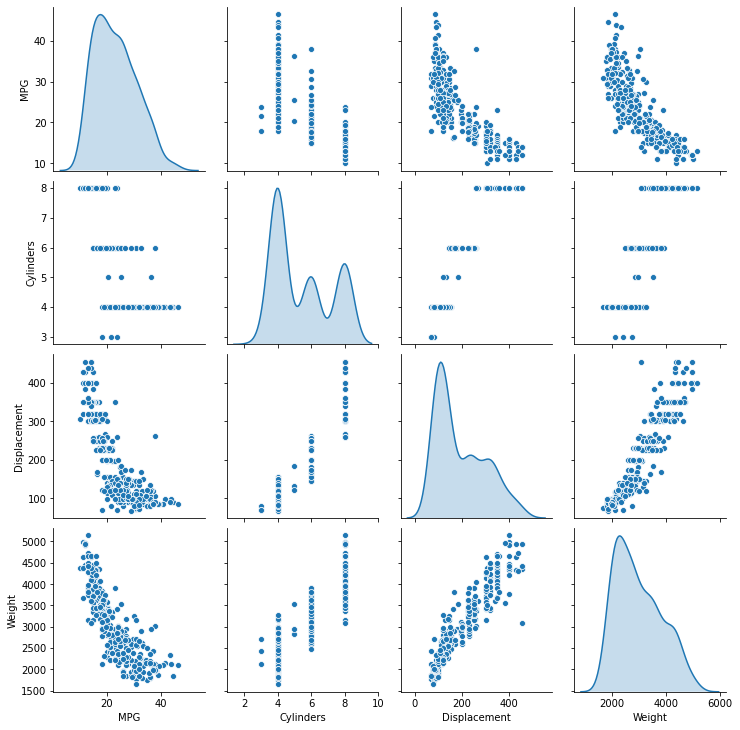

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Repare na visão geral das estatísticas:

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separe features de labels

Separe o valor alvo (*labels*), das *features*. Esta label é o valor no qual o model é treinado para prever.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize os dados

Olhe novamente para o bloco `train_stats` acima e note quão diferente é a variação de feature.

Uma boa prática é normalizar as *features* que usam diferentes escalas e intervalos. Apesar do modelo poder convergir sem a normalização, isso torna o treinamento mais difícil, e torna o resultado do modelo dependente da escolha das unidades da entrada.

Note: embora geramos intencionamente essas estatísticas para os dados de treinamento, essas estatísticas serão usadas também para normalizar o conjunto de teste. Precisamos delinear o conjunto de teste na mesma distribuição que o modelo foi treinado. 

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

O dado normalizado é o que nós usaremos para treinar o modelo.

Caution: A estatística usada para normalizar as entradas aqui (média e desvio padrão) precisa ser aplicada em qualquer outro dado que alimenta o modelo, junto com o codificação one-hot que fizemos mais cedo.  Isso inclui o conjunto de teste, assim como dados que o modelo usará em produção.

## O Modelo

### Construindo o modelo

Vamos construir o modelo. Aqui usaremos o modelo `Sequential` com duas camadas *densely connected*, e a camada de saída que retorna um único valor contínuo. Os passos de construção do modelo são agrupados em uma função, `build_model`, já que criaremos um segundo modelo mais tarde.

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [17]:
model = build_model()

###  Examine o modelo

Use o método `.summary` para exibir uma descrição simples do modelo.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Agora teste o modelo. Pegue um batch de de 10 exemplos do conjunto de treinamento e chame `model.predict` nestes.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03944669],
       [-0.03578506],
       [-0.21960299],
       [-0.02114958],
       [ 0.04014419],
       [-0.1840257 ],
       [ 0.00268198],
       [-0.28146926],
       [-0.14035308],
       [-0.09880331]], dtype=float32)

Parece que está funcionando e ele produz o resultado de forma e tipo esperados.

### Treinando o modelo

Treine o modelo com 1000 *epochs*,  e grave a acurácia do treinamento e da validação em um objeto `history`. 

In [20]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize o progresso do modelo de treinamento usando o estados armazenados no objeto `history`

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.542412,0.999206,2.542412,8.933111,2.342502,8.933111,995
996,2.546079,1.017186,2.546079,8.775246,2.339250,8.775246,996
997,2.532901,1.013452,2.532901,8.623339,2.301519,8.623340,997
998,2.480432,0.977048,2.480432,9.340247,2.346609,9.340247,998
999,2.634855,1.073313,2.634855,8.467946,2.286001,8.467946,999


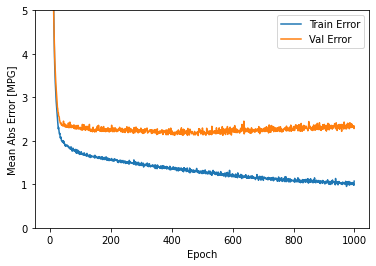

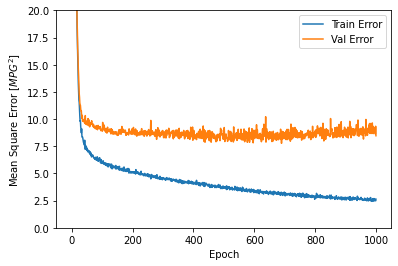

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este grafo mostra as pequenas melhoras, ou mesmo a diminuição do `validation error` após 100 *epochs*. Vamos atualizar o `model.fit` para que pare automaticamente o treinamento quando o `validation score` não aumentar mais. Usaremos o `EarlyStopping callback` que testa a condição do treinamento a cada `epoch`.  Se um grupo de `epochs` decorre sem mostrar melhoras, o treinamento irá parar automaticamente.

Você pode aprender mais sobre este callback [aqui](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


..............................................................................

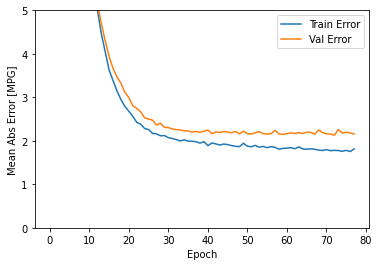

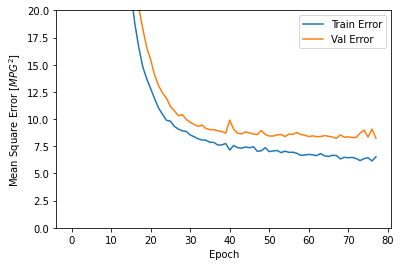

In [23]:
model = build_model()

# O paramêtro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

O gráfico mostra que no conjunto de validação, a média de erro é próximo de +/- 2MPG. Isso é bom? Deixaremos essa decisão a você.

Vamos ver quão bem o modelo generaliza usando o conjunto de **teste**, que não usamos para treinar o modelo. Isso diz quão bem podemos esperar que o modelo se saia quando usarmos na vida real.

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.3424 - mae: 1.8065 - mse: 5.3424
Testing set Mean Abs Error:  1.81 MPG


### Faça predições

Finalmente, prevejamos os valores MPG usando o conjunto de teste.

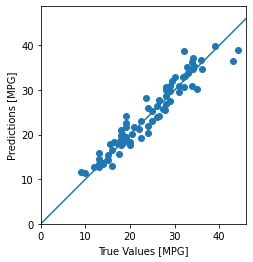

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Parece que o nosso modelo prediz razoavelmente bem. Vamos dar uma olhada na distribuição dos erros.

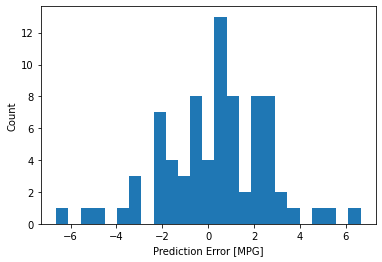

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Não é tão gaussiana, porém podemos esperar que por conta do número de exemplo é bem pequeno.

## Conclusão

Este notebook introduz algumas técnicas para trabalhar com problema de regressão.

* Mean Sqaured Error(MSE), é uma função comum de *loss* usada para problemas de regressão (diferentes funções de *loss* são usadas para problemas de classificação).
* Similarmente, as métricas de evolução usadas na regressão são diferentes da classificação. Uma métrica comum de regressão é  Mean Absolute Error (MAE).
* Quando o dado de entrada de *features*  tem diferentes intervalos, cada *feature* deve ser escalada para o mesmo intervalo.
* Se não possuir muitos dados de treinamento, uma técnica é preferir uma pequena rede com poucas camadas para evitar *overfitting*.
* *Early stopping* é uma boa técnica para evitar *overfitting*.